In [27]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
data = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", low_memory = False);

In [4]:
columns_to_drop = ['id', 'member_id', 'emp_title']
data = data.drop(columns_to_drop, axis = 1)

In [5]:
def initial_model(df, columns, columns_to_encode):
    new_df = df.copy()
    new_df = new_df[columns]
    new_df = pd.get_dummies(new_df, dummy_na = True, columns = columns_to_encode)
    return new_df

In [6]:
cols = ['funded_amnt', 'emp_length', 'home_ownership',
        'annual_inc', 'verification_status', 'dti', 'loan_status', 'revol_util', 'grade']
cols_encode = ['emp_length', 'home_ownership', 'verification_status', 'grade']

new_df = initial_model(data, cols, cols_encode)

In [7]:
def format_revol(val):
    percent = val[:-1]
    return float(percent)/100

new_df['revol_util'] = new_df['revol_util'].map(format_revol, na_action='ignore')

In [8]:
new_df[new_df['revol_util'].isnull()] = np.mean(new_df['revol_util'])

In [9]:
new_df = new_df[new_df.loan_status != 'Current'];

In [10]:
new_df.groupby('loan_status').size()

loan_status
0.5549454866843405       31
Charged Off           10303
Default                  11
Fully Paid            43787
In Grace Period          96
Late (16-30 days)        49
Late (31-120 days)      177
dtype: int64

In [11]:
new_df['paid'] = 1;
new_df.loc[new_df.loan_status == 'Fully Paid', 'paid'] = 0;
display(new_df.head())

,funded_amnt,annual_inc,dti,loan_status,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,...,verification_status_nan,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,paid
0,10400.0,58000.0,14.92,Charged Off,0.316,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,15000.0,78000.0,12.03,Fully Paid,0.290,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
3,7650.0,50000.0,34.81,Charged Off,0.919,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,9600.0,69000.0,25.81,Fully Paid,0.594,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
5,21425.0,63800.0,18.49,Fully Paid,0.762,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [12]:
data_train, data_test = train_test_split(new_df, test_size=.5, stratify=new_df.paid, random_state=99);

In [13]:
def split_data(df, cols):
    x = df.drop(cols, axis = 1)
    y = df.paid
    return x, y

In [14]:
cols_to_drop_training = ['loan_status', 'paid']
x_train, y_train = split_data(data_train, cols_to_drop_training)
x_test, y_test = split_data(data_test, cols_to_drop_training)

In [15]:
model = LogisticRegressionCV(cv = 5, multi_class='ovr', penalty = 'l2')
model.fit(x_train, y_train);

In [16]:
model.score(x_train, y_train)

0.804128255040952

In [17]:
model.score(x_test, y_test)

0.8040915267932567

In [18]:
predictions = x_train.copy()
predictions['pred'] = model.predict(x_train)
predictions['proba'] = model.predict_proba(x_train)[:, 1]
predictions['true_val'] = y_train

In [19]:
predictions.head()

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,pred,proba,true_val
6459,18000.0,76250.0,17.83,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.202184,0
44648,26600.0,74000.0,14.19,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.222867,1
21632,4000.0,15964.0,15.86,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.315521,0
48888,3000.0,36000.0,20.80,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.297255,0
16510,24125.0,52494.0,20.60,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.293019,0


In [20]:
predictions['class'] = 0;
predictions.loc[predictions.proba > 0.39, 'class'] = 1;
display(predictions.head())

,funded_amnt,annual_inc,dti,revol_util,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,grade_C,grade_D,grade_E,grade_F,grade_G,grade_nan,pred,proba,true_val,class
6459,18000.0,76250.0,17.83,0.452,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.202184,0,0
44648,26600.0,74000.0,14.19,0.427,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.222867,1,0
21632,4000.0,15964.0,15.86,0.558,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.315521,0,0
48888,3000.0,36000.0,20.80,0.249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.297255,0,0
16510,24125.0,52494.0,20.60,0.733,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.293019,0,0


In [21]:
accuracy_score(y_train, predictions['class'])

0.803650787820913

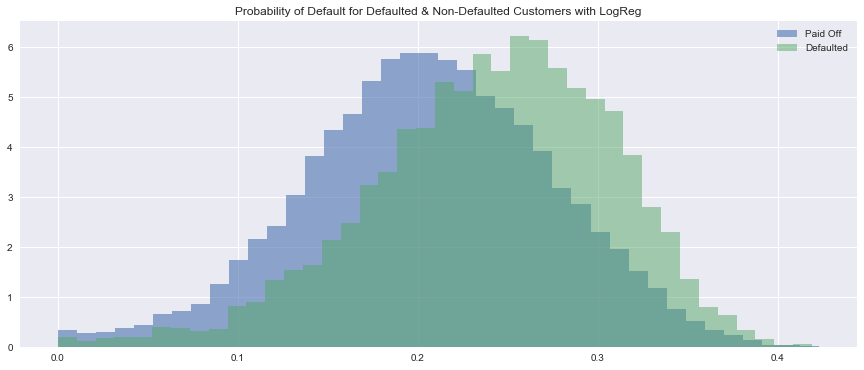

In [33]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);



ax.hist(predictions.loc[predictions.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions.loc[predictions.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LogReg')
ax.legend(loc='best')

plt.show()

In [28]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

/Users/hugoramambason/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [29]:
lda.predict_proba(x_train)

array([[0.86516607, 0.13483393],
       [0.87956393, 0.12043607],
       [0.7490424 , 0.2509576 ],
       ...,
       [0.36975857, 0.63024143],
       [0.93465802, 0.06534198],
       [0.9007097 , 0.0992903 ]])

In [30]:
predictions_lda = x_train.copy()
predictions_lda['pred'] = lda.predict(x_train)
predictions_lda['proba'] = lda.predict_proba(x_train)[:, 1]
predictions_lda['true_val'] = y_train

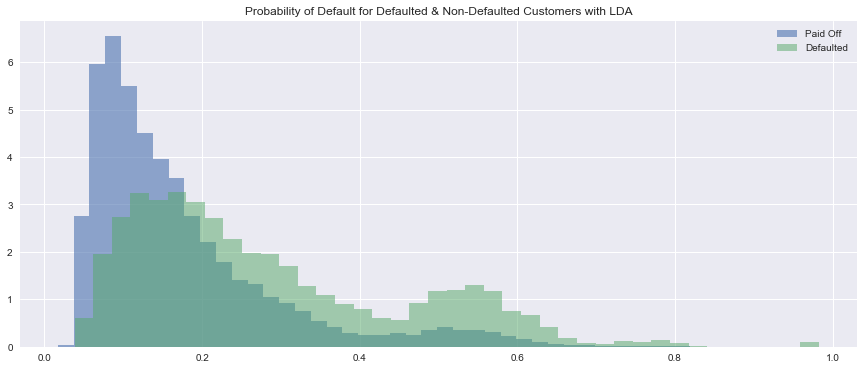

In [34]:
fig = plt.figure(figsize=(15,6));
ax = plt.subplot(1,1,1);

ax.hist(predictions_lda.loc[predictions_lda.true_val == 0,'proba'], density = True, bins = 40, label='Paid Off', alpha=0.6);
ax.hist(predictions_lda.loc[predictions_lda.true_val == 1,'proba'], density = True, bins = 40, label='Defaulted', alpha=0.5);
ax.set_title('Probability of Default for Defaulted & Non-Defaulted Customers with LDA')
ax.legend(loc='best')

plt.show()